# Import libraries

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load the data

In [21]:
data = pd.read_csv('/kaggle/input/bank-customer-churn/Churn_Modelling.csv')\
    .drop('RowNumber', axis = 1)
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [22]:
print(f'No of rows: {data.shape[0]}\nNo of columns: {data.shape[1]}')

No of rows: 10000
No of columns: 13


# EDA

Just a basic EDA as this notebook created to practice model building.

In [23]:
# check if there are missing values
data.isna().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [24]:
# check the number of labels
label_count = data.groupby('Exited').size().to_frame('count').reset_index()
label_count['%'] = label_count['count']/label_count['count'].sum()*100
label_count

,Exited,count,%
0,0,7963,79.63
1,1,2037,20.37


In [25]:
# select the columns to be used in creating the model (features and label)
input_data = data.drop(['CustomerId', 'Surname'], axis = 1)
input_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Overview of Categorical variables

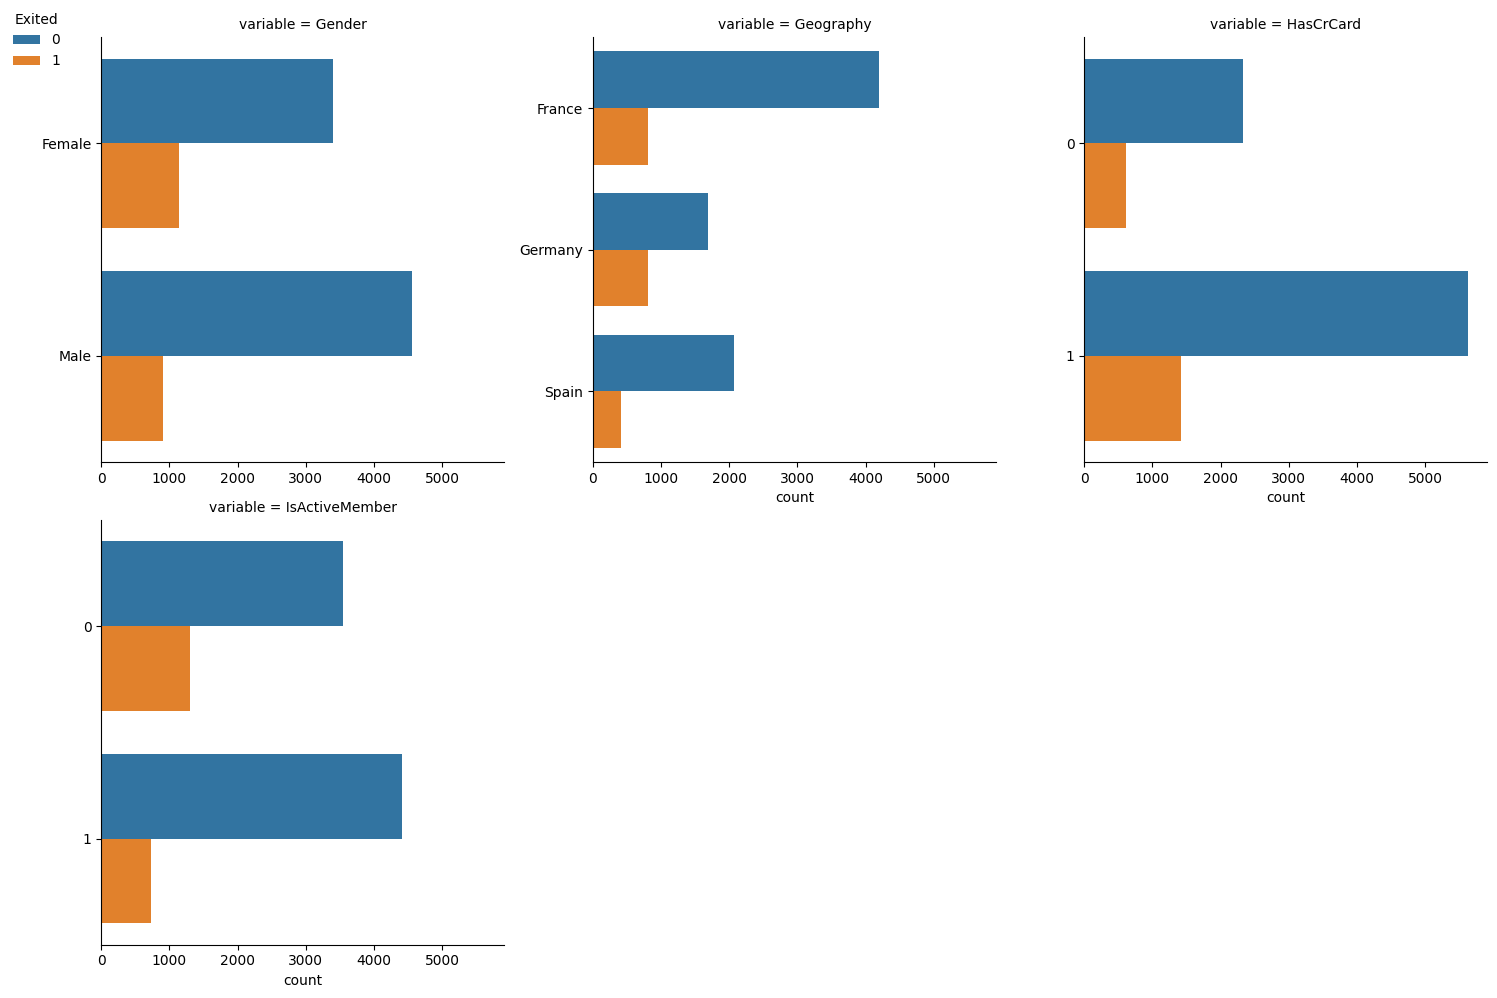

In [26]:
categorical = input_data[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']]

# count of category per variable
val = categorical.melt(value_name = 'category', id_vars = 'Exited')\
    .groupby(['variable', 'category', 'Exited']).size().to_frame('count').reset_index()

g = sns.catplot(
    data=val, x='count', y='category', col='variable', hue = 'Exited', kind='bar', col_wrap=3,
    orient = 'h', sharey = False
)

# show x-label for all facet
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    
sns.move_legend(g, 'upper left')
g.set(ylabel = None);

## Overview of Numerical variables

In [27]:
input_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


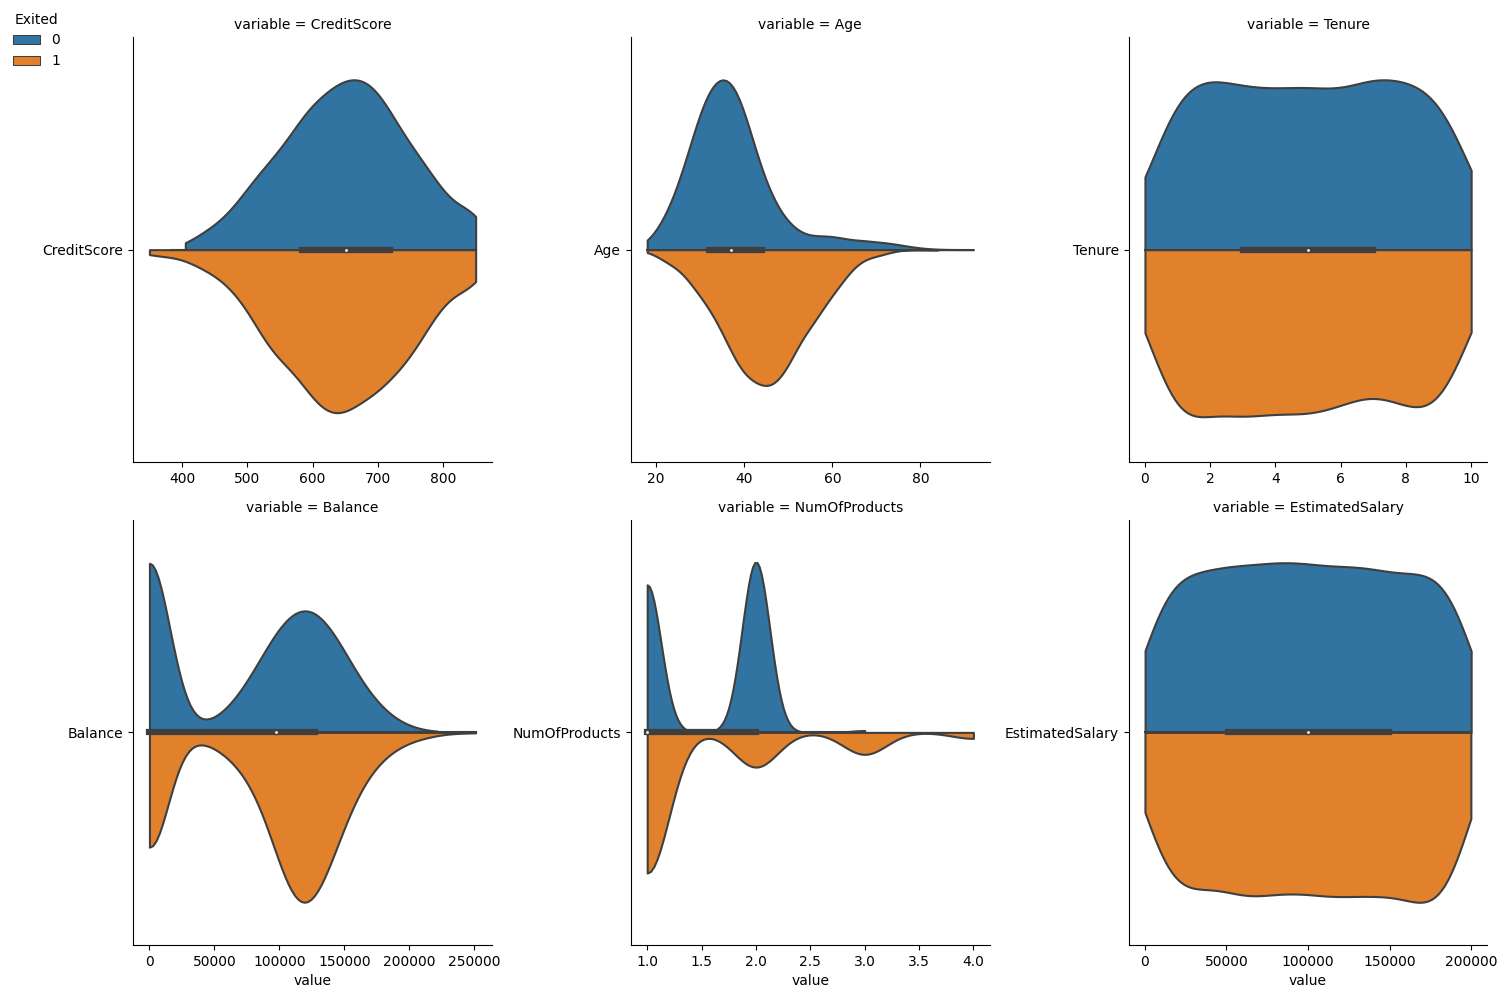

In [28]:
exclude = categorical.columns.tolist().remove('Exited')
exclude

num_df = input_data.drop(categorical, axis = 1)

val = pd.concat([data['Exited'], num_df], axis = 1)\
    .melt(value_name = 'value', id_vars = 'Exited')

# compare the distribution of numeric features based on exit
g = sns.catplot(
    data=val, x='value', y='variable', hue='Exited', hue_order = [0, 1],
    kind='violin', bw=.25, cut=0, split=True, col = 'variable', col_wrap = 3,
    sharey = False, sharex = False
)
g.set(ylabel=None)
sns.move_legend(g, 'upper left');

# One hot encoding
One hot encode Gender and Geography

In [29]:
encoder = OneHotEncoder(sparse_output = False, drop = 'if_binary')
one_hot_encoded = encoder.fit_transform(input_data[['Gender', 'Geography']])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out())

In [30]:
input_data_v1 = input_data.drop(['Geography', 'Gender'], axis = 1)
input_data_v1 = pd.concat([input_data_v1, one_hot_encoded_df], axis = 1)
input_data_v1

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0.0,1.0,0.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,0.0,1.0
2,502,42,8,159660.80,3,1,0,113931.57,1,0.0,1.0,0.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,0,0.0,1.0,0.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1.0,1.0,0.0,0.0
9996,516,35,10,57369.61,1,1,1,101699.77,0,1.0,1.0,0.0,0.0
9997,709,36,7,0.00,1,0,1,42085.58,1,0.0,1.0,0.0,0.0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1.0,0.0,1.0,0.0


# Split the data

In [31]:
X = input_data_v1.drop('Exited', axis = 1)
y = input_data_v1['Exited'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 50,
                                                    shuffle = True, stratify = y)

print(f'Train Dataset -- feature: {X_train.shape[0]} -- label: {y_train.shape[0]}')
print(f'Test Dataset -- feature: {X_test.shape[0]} -- label: {y_test.shape[0]}')

Train Dataset -- feature: 8000 -- label: 8000
Test Dataset -- feature: 2000 -- label: 2000


# Normalize the numeric variables

In [32]:
scaler = MinMaxScaler()

# apply scaler to train data
X_train_scaled = scaler.fit_transform(X_train[num_df.columns])
X_train_scaled = pd.DataFrame(X_train_scaled, columns = num_df.columns, index = X_train.index)
X_train_ = X_train.drop(num_df.columns, axis = 1)
X_train_ = pd.concat([X_train_, X_train_scaled], axis = 1)

# apply scaler to test data (separately apply with train data to avoid data leakage)
X_test_scaled = scaler.transform(X_test[num_df.columns])
X_test_scaled = pd.DataFrame(X_test_scaled, columns = num_df.columns, index = X_test.index)
X_test_ = X_test.drop(num_df.columns, axis = 1)
X_test_ = pd.concat([X_test_, X_test_scaled], axis = 1)

# Convert datasets to tensor

In [33]:
X_train = torch.from_numpy(X_train_.values.astype(np.float32)).to(device)
X_test = torch.from_numpy(X_test_.values.astype(np.float32)).to(device)
y_train = torch.from_numpy(y_train.astype(np.float32)).to(device)
y_test = torch.from_numpy(y_test.astype(np.float32)).to(device)

# Create a model

In [34]:
class classifier(nn.Module):
    def __init__(self, input_features = X_train.shape[1], hidden_units = 15,
                 hidden_layers = 1, dropout = 0.05):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_features, hidden_units))
        layers.append(nn.ReLU())
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_units, 1))
        self.linear_layer_stack = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.linear_layer_stack(x)

In [35]:
%%time
torch.manual_seed(99)
loss_fn = nn.BCEWithLogitsLoss()

def objective(trial):
    hidden_units = trial.suggest_int('hidden_units', 1, 50)
    lr = trial.suggest_float('lr', 0.0001, 0.1)
    hidden_layers = trial.suggest_int('hidden_layers', 1, 10)
    dropout = trial.suggest_float('dropout', 0.1, 0.8)
    epochs = trial.suggest_int('epochs', 1, 100)
    
    # create model
    model = classifier(input_features = 12, hidden_units = hidden_units,
                       hidden_layers = hidden_layers, dropout = dropout).to(device)
    # create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    # create dictionary to save loss for train and test loss curve
    train_loss_dict = {}
    test_loss_dict = {}
    
    for epoch in range(epochs):
        model.train()
        logits = model(X_train).squeeze()
        loss = loss_fn(logits, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_dict[epoch] = loss.detach().cpu().numpy()

        # evaluate the model
        with torch.inference_mode():
            test_logits = model(X_test).squeeze()
            test_loss = loss_fn(test_logits, y_test)

            test_loss_dict[epoch] = test_loss.detach().cpu().numpy()

    test_prediction = torch.round(torch.sigmoid(test_logits)).detach().cpu().numpy()
    test_accuracy = accuracy_score(y_test.detach().cpu().numpy(), test_prediction)
    test_f1 = f1_score(y_test.cpu().numpy(), test_prediction)

    print(f'Test Dataset -- Accuracy: {test_accuracy:.2f} -- F1 Score: {test_f1:.2f}')
    trial.set_user_attr('train_loss_dict', train_loss_dict)
    trial.set_user_attr('test_loss_dict', test_loss_dict)
    trial.set_user_attr('test_prediction', test_prediction)
    
    # use f1 score as the objective function since the data is imbalance
    return test_f1

# run optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar = True,
              gc_after_trial = True)

[I 2024-06-07 10:35:21,888] A new study created in memory with name: no-name-95aa7b96-fb4d-458b-8d71-561a0cf82a9c


  0%|          | 0/100 [00:00<?, ?it/s]

Test Dataset -- Accuracy: 0.80 -- F1 Score: 0.00
[I 2024-06-07 10:35:22,149] Trial 0 finished with value: 0.0 and parameters: {'hidden_units': 10, 'lr': 0.0421263646561928, 'hidden_layers': 7, 'dropout': 0.6338701302321709, 'epochs': 56}. Best is trial 0 with value: 0.0.
Test Dataset -- Accuracy: 0.80 -- F1 Score: 0.00
[I 2024-06-07 10:35:22,496] Trial 1 finished with value: 0.0 and parameters: {'hidden_units': 14, 'lr': 0.08013900169671652, 'hidden_layers': 2, 'dropout': 0.2113050086884013, 'epochs': 72}. Best is trial 0 with value: 0.0.
Test Dataset -- Accuracy: 0.80 -- F1 Score: 0.00
[I 2024-06-07 10:35:22,806] Trial 2 finished with value: 0.0 and parameters: {'hidden_units': 36, 'lr': 0.021036455540803058, 'hidden_layers': 8, 'dropout': 0.5698063317646183, 'epochs': 24}. Best is trial 0 with value: 0.0.
Test Dataset -- Accuracy: 0.80 -- F1 Score: 0.00
[I 2024-06-07 10:35:23,041] Trial 3 finished with value: 0.0 and parameters: {'hidden_units': 47, 'lr': 0.014967854906891578, 'hidde

In [36]:
best_params = study.best_params
best_f1 = study.best_value
print('Best Hyperparameters:', best_params)
print('Best f1:', best_f1)

Best Hyperparameters: {'hidden_units': 41, 'lr': 0.02282550749974246, 'hidden_layers': 4, 'dropout': 0.15607887476097426, 'epochs': 98}
Best f1: 0.6088082901554404


# Plot training vs validation loss

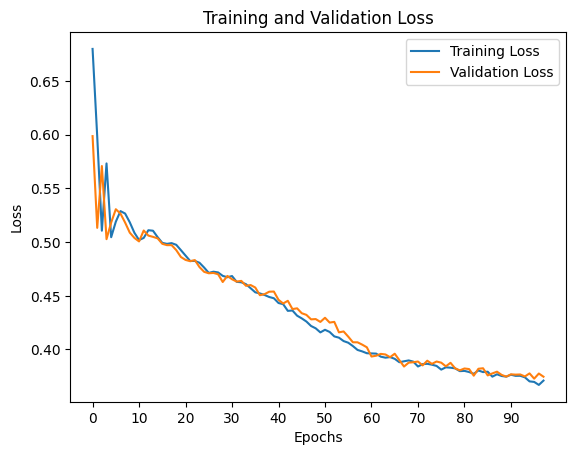

In [37]:
train_values = study.best_trial.user_attrs['train_loss_dict'].values()
test_values = study.best_trial.user_attrs['test_loss_dict'].values()

epochs = range(0, best_params['epochs'])

plt.plot(epochs, train_values, label='Training Loss')
plt.plot(epochs, test_values, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
plt.xticks(np.arange(0, 100, 10))
plt.legend(loc='best')
plt.show()

# Confusion Matrix

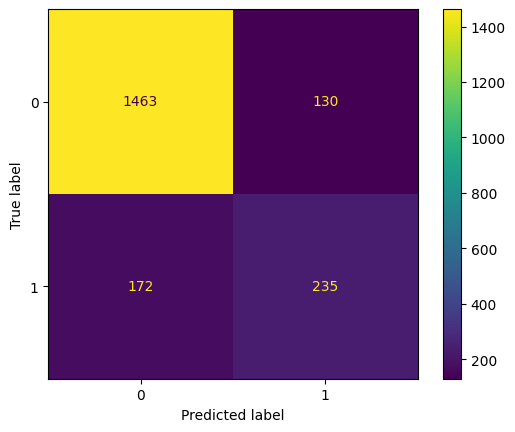

In [38]:
test_prediction = study.best_trial.user_attrs['test_prediction']
cm = confusion_matrix(y_test.cpu().numpy(), test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();